# qwen2-7b 推理和微调 

> 作者: 黎颖; 龙汀汀
>
> 联系方式: yingliclaire@pku.edu.cn;   l.tingting@pku.edu.cn

本章使用一张 A100 运行。

Qwen 系列模型是由阿里巴巴开发的。Qwen 模型系列包括不同规模的模型，参数范围从 0.5 到 720 亿，适用于各种应用场景，如文本生成、翻译、问答等。

Qwen2-7B-Instruct 支持高达 131,072 个 token 的上下文长度，能够处理大量输入。本 tutorial 旨在使用 Qwen2-7B-Instruct 模型展示模型对话、微调训练的过程。

使用的环境如下：

创建conda环境

```bash
conda create -n tutorial6 python=3.9
conda activate tutorial6
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
pip install numpy==1.26.4 matplotlib==3.8.4 ipykernel==6.29.5 transformers==4.42.4
```

## 1. 下载模型

在data shell中下载模型：

```bash
export HF_ENDPOINT=https://hf-mirror.com
huggingface-cli download --resume-download Qwen/Qwen2-7B-Instruct --local-dir models--Qwen--Qwen2-7B-Instruct
```

如果使用 SCOW， 可以从公用存储中加载模型，存储所有模型的路径为：

/lustre/public/tutorial/models/models--Qwen--Qwen2-7B-Instruct

从中找到本节对应的模型加载即可。

## 2. 模型推理

<!-- TODO 模型路径需要修改，除此以外，其余部分的模型路径均需要检查 -->

[[参考链接]](https://huggingface.co/Qwen/Qwen2-7B-Instruct)

运行以下代码：

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# 加载模型和分词器
# VAR_PLACEHOLDER
model_path = "models--Qwen--Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
model.eval()

# 移动模型到 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# prompt
prompt = "介绍一下大模型"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]

# 对话
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

## 3. 模型微调


（运行过程中使用 nvidia-smi 命令可以查看 GPU 运行情况。）

使用 LLaMA Factory 进行微调。首先需要安装 LLaMA Factory，在外部目录下安装，我们安装的目录是：/tutorial-xscow/LLaMA-Factory

关于 LLaMA Factory 项目的详细说明参考： [[参考链接]](https://github.com/hiyouga/LLaMA-Factory)

```bash
git clone --depth 1 https://github.com/hiyouga/LLaMA-Factory.git
cd LLaMA-Factory
pip install -e ".[torch,metrics,deepspeed,qwen]"
```


### 3.1 使用 LLaMA Factory 微调：
在当前目录下的data目录下准备好微调数据集，运行下面的命令进行微调

```bash
llamafactory-cli train qwen_finetune.yaml
```

其中 qwen_finetune.yaml 是本目录下的配置文件，其内容为：


```yaml
# 模型相对路径
# VAR_PLACEHOLDER
model_name_or_path: models--Qwen--Qwen2-7B-Instruct

### method
stage: sft
do_train: true
finetuning_type: lora
lora_target: all

### dataset
dataset_dir: data/ # data 文件需从指定路径下载或自己准备，使用 data/Tutorial_6/data 中的数据即可 # VAR_PLACEHOLDER
dataset: my_identity # 需在 dataset_info.json 中配置，使用 data/Tutorial_6/data 中的配置即可
template: qwen
cutoff_len: 1024
max_samples: 1000
overwrite_cache: true
preprocessing_num_workers: 16

### output
output_dir: saves/qwen-7b # 微调参数保存路径
logging_steps: 10
save_steps: 500
plot_loss: true
overwrite_output_dir: true

### train
per_device_train_batch_size: 4
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 70.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
fp16: true # 原来为 bf16: true
ddp_timeout: 180000000

### eval
val_size: 0.1
per_device_eval_batch_size: 4
eval_strategy: steps
eval_steps: 500
```

### 3.2 合并 Lora 参数：

```bash
llamafactory-cli export qwen_merge.yaml
```

其中 qwen_merge.yaml 是本目录下的配置文件，其内容为：

```yaml
### 模型路径
#  VAR_PLACEHOLDER
model_name_or_path: models--Qwen--Qwen2-7B-Instruct
adapter_name_or_path: saves/qwen-7b # 微调参数路径
template: qwen
finetuning_type: lora

## export
export_dir: outputs/Qwen-7B-Finetuned # 模型合并后导出路径
export_size: 2
export_device: auto
export_legacy_format: false
```

### 3.3 加载合并后的模型

合并后的模型在 outputs/Qwen-7B-Finetuned 目录下。使用下面命令可以进行加载：

```bash
llamafactory-cli chat qwen-chat.yaml
```

其中 qwen-chat.yaml 是本目录下的配置文件，其内容为：

```yaml
# 模型路径
# VAR_PLACEHOLDER
model_name_or_path: models--Qwen--Qwen2-7B-Instruct
template: qwen
```

## 4. 使用 Web UI

上述过程也可以使用图形化的 webui 界面进行。执行下面命令，即可打开 webui 界面。为了避免路径错误，建议在加载模型、导出模型时使用绝对路径。

```bash
llamafactory-cli webui
```

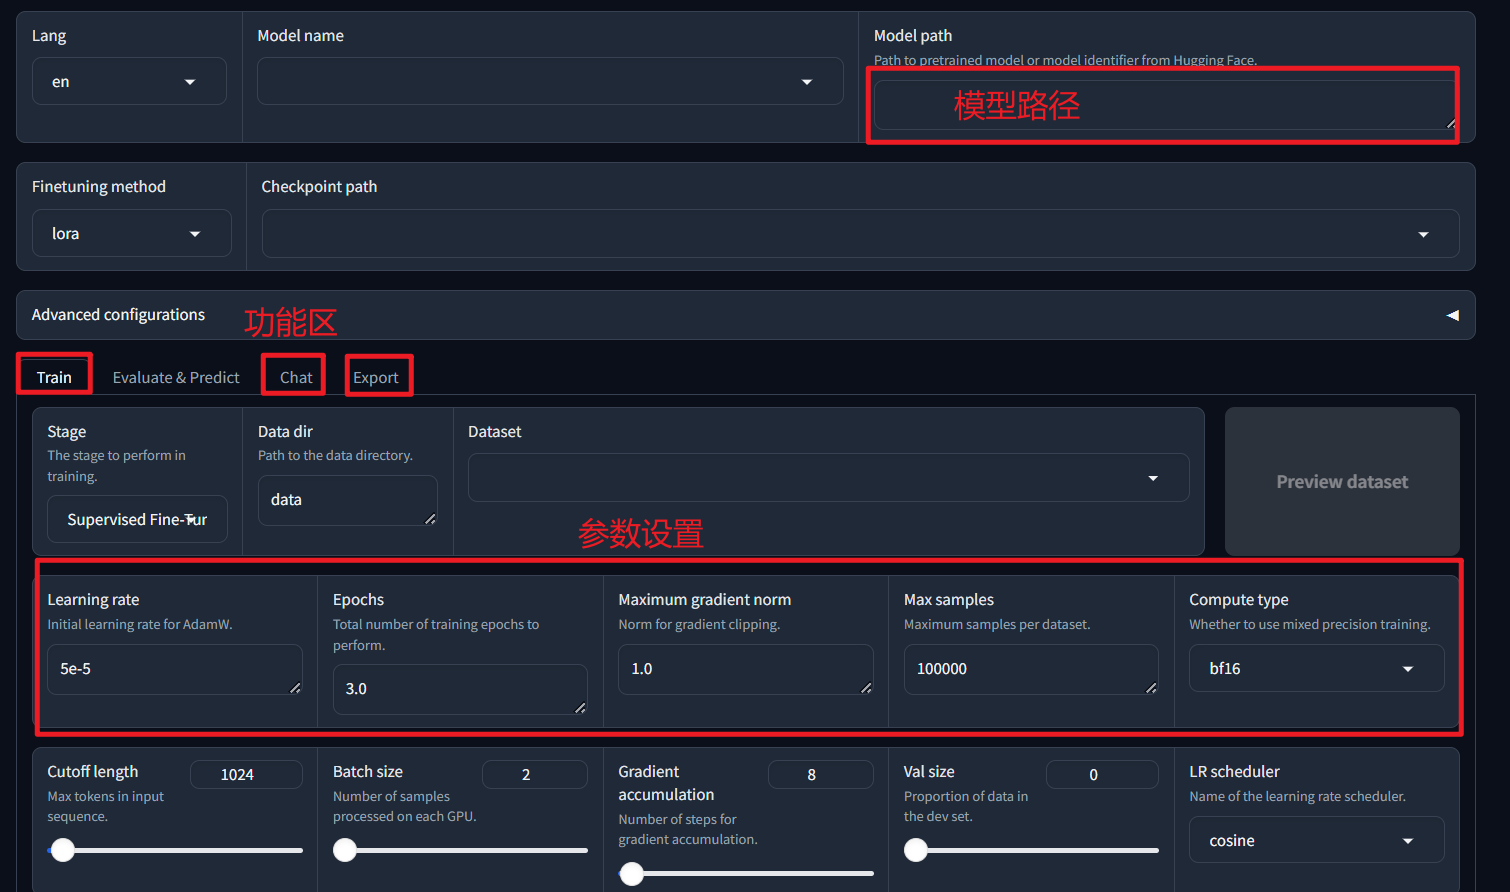